# SYXthDimension

## exploration of DX7 voices through dimension reduction

In [1]:
import glob
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import Normalizer

from sklearn.preprocessing import StandardScaler

import copy

from rtmidi.midiutil import list_output_ports, open_midioutput

In [2]:
# adapted from python-rtmidi examples/sendsysex.py

def openMIDI( midi_port = 0 ):
    try:
        midiout, portname = open_midioutput(midi_port, interactive=False, use_virtual=True)
    except rtmidi.InvalidPortError:
        log.error("Invalid MIDI port number or name.")
        log.error("Use '-l' option to list MIDI ports.")
        return 2
    except rtmidi.RtMidiError as exc:
        log.error(exc)
        return 1
    except (EOFError, KeyboardInterrupt):
        return 0
    
    return midiout, portname

### Specify directory containing .syx files

In [3]:
# syxFiles = glob.glob("/home/abeaudoi/Dropbox/TX816/Benson/*.syx")
# syxFiles = glob.glob("/home/abeaudoi/Dropbox/TX816/Patches/**/*.syx",recursive=True)
syxFiles = glob.glob("/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/**/*.syx",recursive=True)
print('%d files in directory structure.' % len(syxFiles))

797 files in directory structure.


### Open the midi port

In [4]:
midiout, portname = openMIDI()
print(portname)

Midi Through:Midi Through Port-0 14:0


In [5]:
# number of bytes in sxy file to use for dimension reduction

Vbytes = 117
# Vbytes = 102

voiceData = np.zeros((32*len(syxFiles),Vbytes))
nms = [None]*(32*len(syxFiles))
sFnms = [None]*(32*len(syxFiles))

for isF, sF in enumerate(syxFiles):  
    
    try:
        fDX7 = open(sF, "rb")
        
    except OSError:
        print('Could not read ' + sF)
        continue
        
    bf = fDX7.read(-1)

    if len(bf)==4104:
        header_ofst = 6
    else:
        header_ofst = 0

    # Only bulk voice .syx format, but don't require checksum
    
    if len(bf)>=4096:
        for i in range(32): 
        
            ofst = header_ofst + (i*128)

            for j in range(Vbytes):
                voiceData[i+(isF*32),j] = bf[ofst+j]
            nm = ''
            for j in range(10):
                nm += chr(bf[header_ofst+118+(i*128)+j])

            nms[i+(isF*32)]   = nm
            sFnms[i+(isF*32)] = sF
    
    fDX7.close()

### Specify the algorithm

Select the subset of voices having that algorithm

In [6]:
algorithm_select = 13

iDef = np.logical_and(np.sum(voiceData,axis=1) > 0, voiceData[:,110]==algorithm_select) 

print(np.sum(iDef),'voices')

411 voices


In [7]:
voiceIndex = np.arange( voiceData.shape[0])
voiceSubset = voiceData[iDef,:102]
voiceIndex = voiceIndex[iDef]

# transformer = Normalizer().fit(voiceData)
# V_normalized = transformer.transform(voiceData)

V_scaled = StandardScaler().fit_transform(voiceSubset)

In [8]:
# V_embedded = TSNE(n_components=2).fit_transform(V_normalized)
V_embedded = TSNE(n_components=2).fit_transform(voiceSubset)
# V_embedded = TSNE(n_components=2).fit_transform(V_scaled)

In [9]:
def onpickTSNE(event):
    global v_id, xy

    v_id = voiceIndex[ np.argmin( np.linalg.norm(V_embedded-np.array((event.xdata, event.ydata)),axis=1) ) ]
    tx = str(v_id%32) + '-->' + nms[v_id] 
    ax1.set_title(tx)
    xy = np.array((event.xdata,event.ydata))

<IPython.core.display.Javascript object>


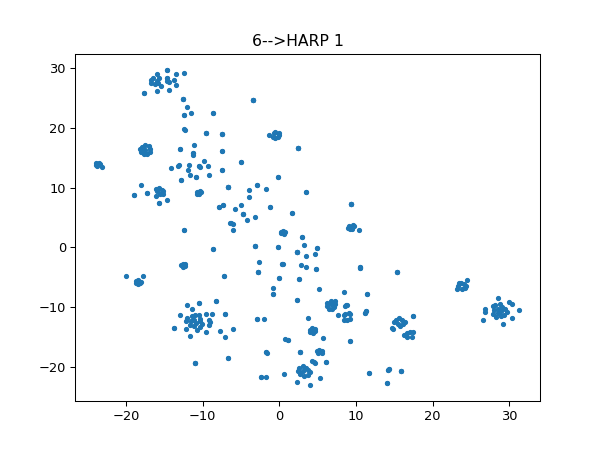

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(V_embedded[:,0],V_embedded[:,1],'.')
# text = ax1.text(-10,20, "test", va="bottom", ha="left")
ax1.set_title('')
v_id = fig.canvas.mpl_connect('button_press_event', onpickTSNE)

### Prepare .syx file 

Select the 32 voices closest to selection.  Use first six bytes and final byte from last .syx file read.

The checksum on the data for the 32 voices (32*128=4096 bytes) is computed as

$$\left( \sum_{i=0}^{127} d_i \right) \mod 256 - c  = 0 $$,
where $d_i$ are data bytes and $c$ is the checksum.  So,
$$c = \left( \sum_{i=0}^{127} d_i \right) \mod 256 $$.

Apply mask to zero the highest bit.

In [19]:
dist = np.linalg.norm(V_embedded-xy,axis=1)
v_idx = voiceIndex[ np.argsort( dist ) ]

bulk_voice = bytearray( 4104*b' ' )


# Header for bulk voice syx message

bulk_voice[:6] = bytearray(b'\xf0C\x00\t \x00')

for i in range(32):
    ii = v_idx[i]
    print(sFnms[ii],ii%32,nms[ii])
    
    fDX7 = open(sFnms[ii], "rb")
    bf = fDX7.read(-1)
    fDX7.close()
    
    if len(bf)==4104:
        iOut, iIn = 6 + i*128, 6 + (ii%32)*128
    else:
        iOut, iIn = i*128, (ii%32)*128
        
    bulk_voice[iOut:(iOut+128)] = bf[iIn:(iIn+128)]
    
# Copy header from any bulk voice .syx file
for i in range(6):
    bulk_voice[i] = bf[i]
    
cs = int(0)

for bt in bulk_voice[6:(6+4096)]:
    cs -= bt

# twos complement checksum
bulk_voice[-2] = (cs % 256) & 0x7F

bulk_voice[-1] = bf[-1]

/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/Aminet/068.syx 6 HARP 1    
/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/!Instruments/Plucked/Harp/harp_1.syx 12 HARP   13 
/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/!Instruments/Plucked/Guitar/Guitar4/Guitars.syx 19 HARP 1    
/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/Aminet/108.syx 10 HARP    1 
/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/!Instruments/Plucked/Harp/harp_2.syx 24 HARP    1 
/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/Aminet/071.syx 7 HARP MCK1 
/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/!Unsorted/Chris Dodunski/Mark.syx 17 HARP    1 
/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/!Instruments/Plucked/Harp/harp_1.syx 3 HARP    4 
/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/!Unsorted/Chris Dodunski/Steph3.syx 28 HARP    1 
/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/Godric/pluck3.syx 2 Harp  1   
/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/!Unsorted/dx7zicweb/esipa.syx 3 HARP    1 
/home/abeaudoi/Dropbox/TX816/Dexed_Cart_1_0/A

### Send the 32 voices

In [20]:
# log.info("Sending '%s' message #%03i...", bn, i)
midiout.send_message( bytes(bulk_voice) )

### Clean up

In [ ]:
midiout.close_port()
del midiout